<a href="https://colab.research.google.com/github/kanzaki-coder/deeplearning/blob/master/weed_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image 
from keras import models
import os 
import numpy as np
my_model = models.load_model('/content/drive/My Drive/weed_type.h5')

In [0]:
#20分類のclassを入力
#芽生えの場合は1育成済みなら2を後ろに追加
classes=["hakidamegiku","hakidamegiku","hosoaogeitou","hosoaogeitou","ichibi",
         "ichibi","inubie","inubie","kosendangusa","kosendangusa","mameasagao",
         "mameasagao","mehishiba","mehishiba","ohishiba","ohishiba","oinutade",
         "oinutade","shiroza","shiroza"]


In [0]:
#10分類のclassを入力
classes=["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao",
         "mehishiba","ohishiba","oinutade","shiroza"]

In [0]:
#7分類のclassを入力
classes=["kikuf","hosoaogeitou","ichibi","inef","mameasagao","oinutade","shiroza"]

In [26]:
# 画像のパスを取得

#img_path = "/content/cluster01/shiroza/shiroza_IMG_1542_19.JPG"
img_path="/content/drive/My Drive/cluster0312/hakidamegiku1/hakidamegiku_IMG_1524_1.JPG"

# データの前処理
img = image.load_img(img_path, target_size=(224, 224))

# xは形状が(224,224,3)のfloat32型のnumpy配列
x = image.img_to_array(img)/255.0

# この配列サイズが(1, 224, 224, 3)のバッチに変換するために次元を追加
x = np.expand_dims(x, axis=0)
preds = my_model.predict(x)
print(np.argmax(preds[0]))
print(preds[0])
pred_label = np.argmax(preds[0])
print("この画像は"+classes[pred_label]+"です")

0
[9.9937493e-01 1.3895895e-04 6.5739609e-05 2.1873124e-05 1.8915308e-08
 1.4513670e-07 1.7532432e-06 2.6167756e-06 3.3792329e-04 5.6029166e-05]
この画像はhakidamegikuです


(14, 14)


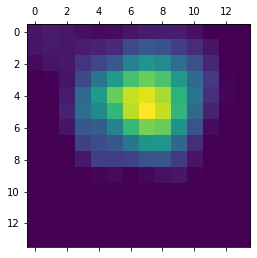

In [13]:
last_layer_name='block5_conv3'
# 予測ベクトル
output = my_model.output[:,np.argmax(preds[0])]
# 最後の層である
last_conv_layer = my_model.get_layer(last_layer_name)
# conv2d_15の出力特徴マップでのクラス勾配
grads = K.gradients(output,last_conv_layer.output)[0]

# 形状が(32, )のベクトル
# 各エントリは特定の特徴マップの平均強度
pooled_grads = K.mean(grads,axis=(0,1,2))
#Audi-a3の画像に基づいてpooled_gradsとconv2d_15の出力マップの値にアクセスするための関数
iterate = K.function([my_model.input], [pooled_grads, last_conv_layer.output[0]])

# 2つの値をNumpy配列で取得
pooled_grads_value, conv_layer_output_value = iterate([x])

# クラスに関する「このチャネルの重要度」を特徴マップ配列の各チャネルに掛ける
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

# 最終的な特徴マップのチャネルごとの平均値がクラスの活性化のヒートマップ
heatmap = np.mean(conv_layer_output_value,axis=-1 )

# ヒートマップの後処理
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [14]:
import cv2
# cv2を使って画像読み込み
img = cv2.imread(img_path)
# 元画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)
# ヒートマップをもとの画像に適応
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4はヒートマップの強度係数
superimporsed_img = heatmap * 0.4 + img
# 画像を保存
cv2.imwrite('保存したい名前1.jpg',superimporsed_img)

True

<function matplotlib.pyplot.show>

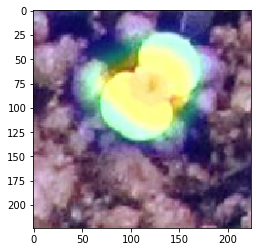

In [16]:
img = image.load_img('保存したい名前1.jpg', target_size=(224,224))
img_tensor = image.img_to_array(img)
img_tensor /= 255.
plt.imshow(img_tensor)
plt.show